<a href="https://colab.research.google.com/github/PlantInGreenhouse/DS_TermProject_9/blob/main/modeling_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Function to evaluate the model
def evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2

# Define dataset paths
datasets = {
    'StandardScaler_ZScore': 'termproject/preprocessed_data_standardized.csv',
    'Normalizer_ZScore': 'termproject/preprocessed_data_normalized.csv',
    'MinMaxScaler_ZScore': 'termproject/preprocessed_data_2.csv',
    'MinMaxScaler_LabelEncoder': 'termproject/preprocessed_data.csv',
    'Normalizer_IQR': 'termproject/preprocessed_data_normalized_iqr.csv',
    'StandardScaler_IQR': 'termproject/preprocessed_data_standard_iqr.csv',
}

# Define models to be used
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

# Initialize a list to store results
results = []

# Evaluate each combination of dataset and model
for dataset_name, filepath in datasets.items():
    try:
        # Load the dataset
        data = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"File {filepath} not found.")
        continue

    # Separate features and target variable
    X = data.drop(columns=['salary_in_usd'])
    y = data['salary_in_usd']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate each model
    for model_name, model in models.items():
        mse, mae, r2 = evaluate_model(X_train, X_test, y_train, y_test, model)
        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'MSE': mse,
            'MAE': mae,
            'R^2': r2
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Rank each metric
results_df['MSE_rank'] = results_df['MSE'].rank(ascending=True)  # MSE: lower is better
results_df['MAE_rank'] = results_df['MAE'].rank(ascending=True)  # MAE: lower is better
results_df['R^2_rank'] = results_df['R^2'].rank(ascending=False)  # R^2: higher is better

# Calculate total rank
results_df['Total_rank'] = results_df[['MSE_rank', 'MAE_rank', 'R^2_rank']].mean(axis=1)

# Select the top 5 combinations by overall rank
top_5_overall = results_df.nsmallest(5, 'Total_rank')

# Print the results
print("Top 5 Combinations by Overall Rank:")
print(top_5_overall)


Top 5 Combinations by Overall Rank:
               Dataset                      Model           MSE           MAE  \
23  StandardScaler_IQR  GradientBoostingRegressor  2.505615e+09  39240.301172   
22  StandardScaler_IQR      RandomForestRegressor  2.514135e+09  39198.781365   
6    Normalizer_ZScore      RandomForestRegressor  2.658174e+09  40112.192319   
19      Normalizer_IQR  GradientBoostingRegressor  2.519150e+09  39320.923966   
18      Normalizer_IQR      RandomForestRegressor  2.553943e+09  39323.915759   

         R^2  MSE_rank  MAE_rank  R^2_rank  Total_rank  
23  0.271188       1.0       2.0       7.0    3.333333  
22  0.268710       2.0       1.0       8.0    3.666667  
6   0.276663       6.0       7.0       1.0    4.666667  
19  0.267251       3.0       3.0      10.0    5.333333  
18  0.257131       4.0       4.0      12.0    6.666667  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
data = pd.read_csv('termproject/preprocessed_data_standard_iqr.csv')

# Separate features and target
X = data.drop(columns=['salary_in_usd'])
y = data['salary_in_usd']

# Function to evaluate GradientBoostingRegressor with k-fold cross-validation
def evaluate_gbr_kfold(X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores = []
    mae_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        gbr = GradientBoostingRegressor()
        gbr.fit(X_train, y_train)
        y_pred = gbr.predict(X_test)

        mse_scores.append(mean_squared_error(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    avg_mse = np.mean(mse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)

    return avg_mse, avg_mae, avg_r2

# Evaluate GradientBoostingRegressor for k from 2 to 10
results = []
best_score = float('-inf')
best_k = None

for k in range(2, 11):
    avg_mse, avg_mae, avg_r2 = evaluate_gbr_kfold(X, y, k)
    results.append({'k': k, 'Average MSE': avg_mse, 'Average MAE': avg_mae, 'Average R²': avg_r2})

    if avg_r2 > best_score:
        best_score = avg_r2
        best_k = k

results_df = pd.DataFrame(results)
print(results_df)

print(f"Best K: {best_k}")

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
gbr = GradientBoostingRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}

# Define the cross-validation strategy with the best k
cv = KFold(n_splits=best_k, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_gbr = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = best_gbr.predict(X_test)

# Calculate evaluation metrics for regression
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test set evaluation metrics with optimal k:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")


    k   Average MSE   Average MAE  Average R²
0   2  2.413796e+09  39024.777783    0.280883
1   3  2.406227e+09  38898.896852    0.283752
2   4  2.385929e+09  38783.552382    0.289593
3   5  2.378172e+09  38736.314425    0.291880
4   6  2.373459e+09  38695.402315    0.292322
5   7  2.369521e+09  38652.481717    0.294428
6   8  2.371063e+09  38684.235660    0.293606
7   9  2.378771e+09  38684.185935    0.291515
8  10  2.368949e+09  38671.970983    0.294127
Best K: 7
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Test set evaluation metrics with optimal k:
MSE: 2500293311.803422
MAE: 39136.61944479414
R^2: 0.2727356705994495


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Function to evaluate classification models
def evaluate_classification_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, recall, f1

# Define dataset paths
datasets = {
    'StandardScaler_ZScore': 'termproject/preprocessed_data_standardized.csv',
    'Normalizer_ZScore': 'termproject/preprocessed_data_normalized.csv',
    'MinMaxScaler_ZScore': 'termproject/preprocessed_data_2.csv',
    'MinMaxScaler_LabelEncoder': 'termproject/preprocessed_data.csv',
    'Normalizer_IQR': 'termproject/preprocessed_data_normalized_iqr.csv',
    'StandardScaler_IQR': 'termproject/preprocessed_data_standard_iqr.csv',
}

# Define models to be used
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
}

# Initialize a list to store results
results = []

# Evaluate each combination of dataset and model
for dataset_name, filepath in datasets.items():
    try:
        # Load the dataset
        data = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"File {filepath} not found.")
        continue

    # Separate features and target variable
    X = data.drop(columns=['salary_in_usd'])
    y = data['salary_in_usd']

    # Convert target variable to categorical (for classification)
    y = pd.qcut(y, q=3, labels=[0, 1, 2])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate each model
    for model_name, model in models.items():
        accuracy, precision, recall, f1 = evaluate_classification_model(X_train, X_test, y_train, y_test, model)
        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Rank each metric
results_df['Accuracy_rank'] = results_df['Accuracy'].rank(ascending=False)  # Accuracy: higher is better
results_df['Precision_rank'] = results_df['Precision'].rank(ascending=False)  # Precision: higher is better
results_df['Recall_rank'] = results_df['Recall'].rank(ascending=False)  # Recall: higher is better
results_df['F1_rank'] = results_df['F1 Score'].rank(ascending=False)  # F1 Score: higher is better

# Calculate total rank
results_df['Total_rank'] = results_df[['Accuracy_rank', 'Precision_rank', 'Recall_rank', 'F1_rank']].mean(axis=1)

# Select the top 5 combinations by overall rank
top_5_overall = results_df.nsmallest(5, 'Total_rank')

# Print the results
print("Top 5 Combinations by Overall Rank:")
print(top_5_overall)


Top 5 Combinations by Overall Rank:
                      Dataset                   Model  Accuracy  Precision  \
22         StandardScaler_IQR  RandomForestClassifier  0.539919   0.536905   
18             Normalizer_IQR  RandomForestClassifier  0.535859   0.532299   
21         StandardScaler_IQR  DecisionTreeClassifier  0.534506   0.533239   
17             Normalizer_IQR  DecisionTreeClassifier  0.527740   0.524488   
14  MinMaxScaler_LabelEncoder  RandomForestClassifier  0.503347   0.505663   

      Recall  F1 Score  Accuracy_rank  Precision_rank  Recall_rank  F1_rank  \
22  0.539919  0.533950            1.0             1.0          1.0      1.0   
18  0.535859  0.529732            2.0             3.0          2.0      2.0   
21  0.534506  0.529345            3.0             2.0          3.0      3.0   
17  0.527740  0.522468            4.0             4.0          4.0      4.0   
14  0.503347  0.504204           10.0             7.0         10.0      5.0   

    Total_rank  
22 

Best k: 5
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.5263870094722598
Precision: 0.508700462044154
Recall: 0.5263870094722598
F1 Score: 0.48713605726860704
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       232
           1       0.40      0.16      0.23       248
           2       0.50      0.81      0.62       259

    accuracy                           0.53       739
   macro avg       0.51      0.52      0.49       739
weighted avg       0.51      0.53      0.49       739



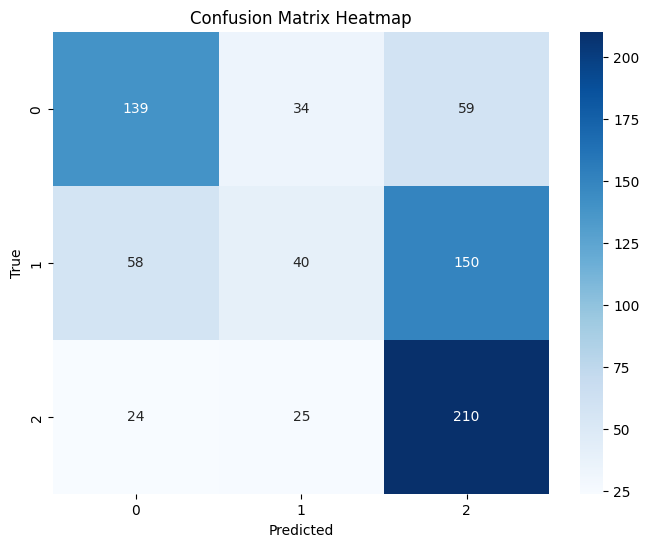

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('termproject/preprocessed_data_standard_iqr.csv')

# Separate features and target
X = data.drop(columns=['salary_in_usd'])
y = data['salary_in_usd']

# Convert target to categorical for classification
y_class = pd.qcut(y, q=3, labels=[0, 1, 2])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Function to find the best k value for k-fold cross-validation
def find_best_k(X, y, model, k_range):
    best_k = None
    best_score = 0
    for k in k_range:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_k = k
    return best_k

# Define the RandomForestClassifier model
rfc = RandomForestClassifier(random_state=42)

# Find the best k value
k_range = range(2, 11)
best_k = find_best_k(X_train, y_train, rfc, k_range)
print(f"Best k: {best_k}")

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Define the cross-validation strategy with the best k
cv = KFold(n_splits=best_k, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_rfc = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = best_rfc.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(class_report)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


Best k: 9
Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
Accuracy: 0.5263870094722598
Precision: 0.5103372889989882
Recall: 0.5263870094722598
F1 Score: 0.48749792052552654
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.58      0.61       232
           1       0.41      0.17      0.23       248
           2       0.50      0.82      0.62       259

    accuracy                           0.53       739
   macro avg       0.51      0.52      0.49       739
weighted avg       0.51      0.53      0.49       739



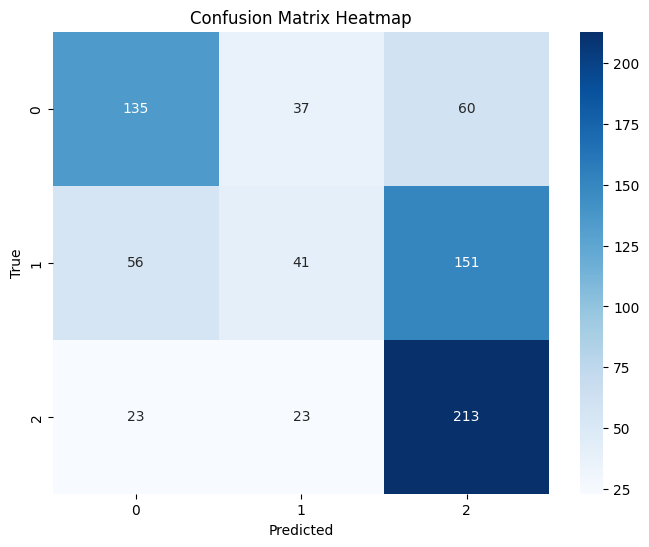

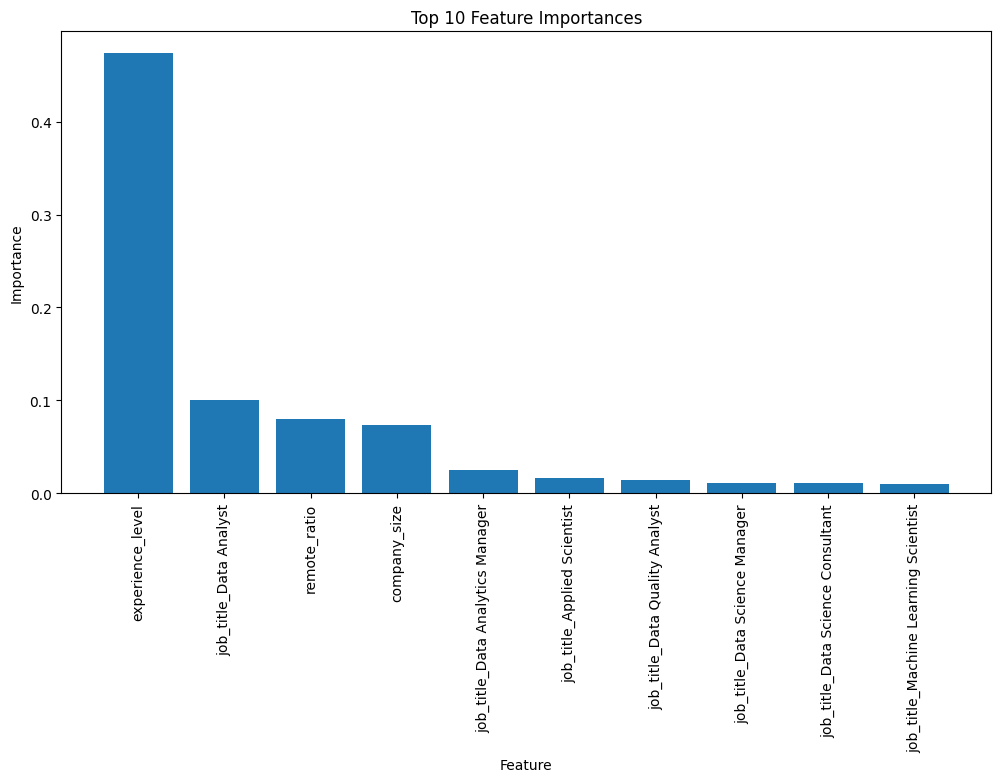

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('termproject/preprocessed_data_standard_iqr.csv')

# Separate features and target
X = data.drop(columns=['salary_in_usd'])
y = data['salary_in_usd']

# Convert target to categorical for classification
y_class = pd.qcut(y, q=3, labels=[0, 1, 2])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Function to find the best k value for k-fold cross-validation
def find_best_k(X, y, model, k_range):
    best_k = None
    best_score = 0
    for k in k_range:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_k = k
    return best_k

# Define the GradientBoostingClassifier model
gbc = GradientBoostingClassifier(random_state=42)

# Find the best k value
k_range = range(2, 11)
best_k = find_best_k(X_train, y_train, gbc, k_range)
print(f"Best k: {best_k}")

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}

# Define the cross-validation strategy with the best k
cv = KFold(n_splits=best_k, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_gbc = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = best_gbc.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(class_report)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Plot feature importance
feature_importances = best_gbc.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), feature_importances[indices][:10], align='center')
plt.xticks(range(10), features[indices][:10], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()